In [1]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!nvidia-smi

Mon Jan 25 11:57:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import os.path as pth
import json
import shutil
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
tf.__version__

'2.4.0'

In [5]:
BASE_MODEL_NAME = 'MobileNetV2-for-upload'
my_model_base = keras.applications.mobilenet_v2
my_model = my_model_base.MobileNetV2

config = {
    'is_zscore':True,
    
    # 'input_shape': (540, 960, 3),
    'aug': {
        'resize': (270, 480),
    },
    # 'input_shape': (224, 360, 3),
    'input_shape': (270, 480, 3),

    'output_activation': 'softmax',
    'num_class': 1049,
    'output_size': 1049,
    
    'conv':{
        'conv_num': (0), # (3,5,3),
        'base_channel': 0, # 4,
        'kernel_size': 0, # 3,
        'padding':'same',
        'stride':'X'
    },
    'pool':{
        'type':'X',
        'size':'X',
        'stride':'X',
        'padding':'same'
    },
    'fc':{
        'fc_num': 0,
     },
    
    'activation':'relu',
    
    'between_type': 'max_avg',
    
    'is_batchnorm': True,
    'is_dropout': False,
    'dropout_rate': 0.5,
    
    'batch_size': 64,
    'buffer_size': 256,
    'loss': 'CategoricalCrossentropy',
    
    'num_epoch': 20,
    'learning_rate': 1e-3,
    
    'random_state': 7777
}

In [6]:
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['randmark_id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def resize_and_crop_func(image, label):
    result_image = tf.image.resize(image, config['aug']['resize'])
    # result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)
    return result_image, label

def image_aug_func(image, label):
    pass
    return image, label

def post_process_func(image, label):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    onehot_label = tf.one_hot(label, depth=config['num_class'])
    return result_image, onehot_label

In [7]:
data_base_path = '/content/drive/MyDrive/data/public'
os.makedirs(data_base_path, exist_ok=True)

In [8]:
category_csv_name = 'category.csv'
category_json_name = 'category.json'
submission_csv_name = 'sample_submisstion.csv'
train_csv_name = 'train.csv'

# train_zip_name = 'train.zip'
train_tfrecord_name = 'all_train.tfrecords'
train_tfrecord_path = pth.join(data_base_path, train_tfrecord_name)
val_tfrecord_name = 'all_val.tfrecords'
val_tfrecord_path = pth.join(data_base_path, val_tfrecord_name)
# test_zip_name = 'test.zip'
test_tfrecord_name = 'test.tfrecords'
test_tfrecord_path = pth.join(data_base_path, test_tfrecord_name)

In [9]:
train_csv_path = '/content/drive/MyDrive/data/public/train.csv'
train_df = pd.read_csv(train_csv_path)
train_dict = {k:v for k, v in train_df.values}

submission_csv_path = pth.join(data_base_path, submission_csv_name)
submission_df = pd.read_csv(submission_csv_path)
# submission_df.head()

category_csv_path = pth.join(data_base_path, category_csv_name)
category_df = pd.read_csv(category_csv_path)
category_dict = {k:v for k, v in category_df.values}
# category_df.head()

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import os
import os.path as pth
import shutil
import time
from tqdm import tqdm

import itertools
from itertools import product, combinations

import numpy as np
from PIL import Image

from IPython.display import clear_output

from multiprocessing import Process, Queue
import datetime

import tensorflow.keras as keras

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv3D, AveragePooling3D, MaxPooling3D, Dropout, \
                                    Concatenate, GlobalMaxPool3D, GlobalAvgPool3D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import max_norm

In [11]:
conv_comb_list = []
conv_comb_list += [(0,)]

base_channel_list = [0]

fc_list = [0] # 128, 0

# between_type_list = [None, 'avg', 'max']
between_type_list = ['max_avg']

batch_size_list = [80]

activation_list = ['relu']

# len(conv_comb_list), conv_comb_list

In [12]:
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D

def build_cnn(config):
    input_layer = Input(shape=config['input_shape'], name='input_layer')
    pret_model = my_model(
        input_tensor=input_layer, include_top=False, weights='imagenet', 
        input_shape=config['input_shape'], pooling=config['between_type'], 
        classes=config['output_size']
    )

    pret_model.trainable = False
    
    x = pret_model.output
    
    if config['between_type'] == 'max_avg':
      x1 = MaxPool2D(name='max_avg_1')(x)
      x2 = AveragePooling2D(name='max_avg_2')(x)
      x = (x1 + x2)/2
      x= Flatten(name='Flatten')(x)
      
    if config['is_dropout']:
        x = Dropout(config['dropout_rate'], name='output_dropout')(x)    
            
    x = Dense(config['output_size'], activation=config['output_activation'], 
          name='output_fc')(x)
#     x = Activation(activation=config['output_activation'], name='output_activation')(x)
    model = Model(inputs=input_layer, outputs=x, name='{}'.format(BASE_MODEL_NAME))

    return model

In [13]:
model = build_cnn(config)
model.summary(line_length=150)
del model

9412608/9406464 [==============================] - 0s 0us/step
Model: "MobileNetV2-for-upload"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_layer (InputLayer)                         [(None, 270, 480, 3)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
Conv1 (Conv2D)                                   (None, 135, 240, 32)             864               input_layer[0][0]                                 
______________________________________________________________________________________________________________________________________________________

In [14]:
origin_train_len = len(train_df) / 5 * 4
origin_val_len = len(train_df) / 5 * 1

train_num_steps = int(np.ceil((origin_train_len)/config['batch_size']))
val_num_steps = int(np.ceil((origin_val_len)/config['batch_size']))

In [15]:
model_base_path = data_base_path
model_checkpoint_path = pth.join(model_base_path, 'checkpoint')

MobileNetV2-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg2_fc_0_zscore_True_batch_80_BN_O
Epoch 11/20
882/882 [==============================] - 747s 842ms/step - loss: 0.1076 - acc: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9975 - val_loss: 4.6673 - val_acc: 0.8840 - val_precision: 0.8846 - val_recall: 0.8839 - val_auc: 0.9475

Epoch 00011: val_loss improved from inf to 4.66735, saving model to /content/drive/MyDrive/data/public/checkpoint/MobileNetV2-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg2_fc_0_zscore_True_batch_80_BN_O/000011-4.667349-0.127366.hdf5
Epoch 12/20
882/882 [==============================] - 740s 837ms/step - loss: 0.1477 - acc: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9969 - val_loss: 5.8044 - val_acc: 0.8697 - val_precision: 0.8707 - val_recall: 0.8696 - val_auc: 0.9413

Epoch 00012: val_loss did not improve from 4.66735
Epoch 13/20
882/882 [==============================] - 739s 836ms/step - loss: 0.1756 -

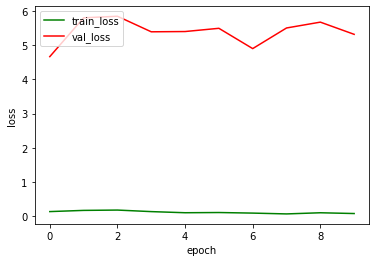

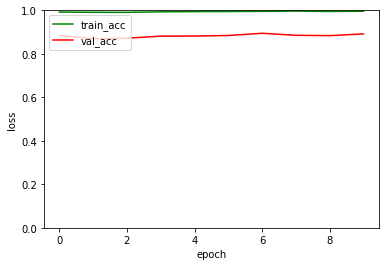

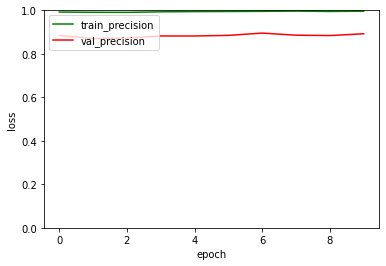

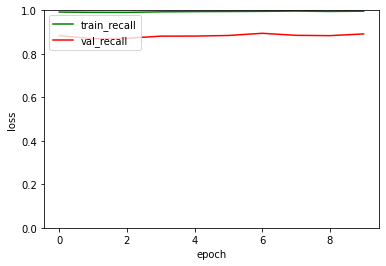

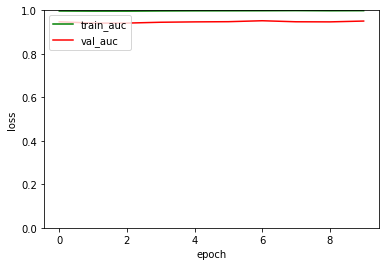

IsADirectoryError: ignored

In [146]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # dataset = dataset.cache()
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(config['buffer_size'])
    dataset = dataset.batch(config['batch_size'])
    dataset = dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.TFRecordDataset(val_tfrecord_path, compression_type='GZIP')
    val_dataset = val_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.shuffle(config['buffer_size'])
    val_dataset = val_dataset.batch(config['batch_size'])
    val_dataset = val_dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.cache()
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    if pth.isdir(model_path) and len([_ for _ in os.listdir(model_path) if _.endswith('hdf5')]) >= 1:
        model_chk_name = sorted(os.listdir(model_path))[-1]
        initial_epoch = int(model_chk_name.split('-')[0])
        model.load_weights(pth.join(model_path, model_chk_name))

    # ### Freeze first layer
    # conv_list = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)]
    # conv_list[0].trainable = False
    # # conv_list[1].trainable = False

    os.makedirs(model_path, exist_ok=True)
    model_filename = pth.join(model_path, '{epoch:06d}-{val_loss:0.6f}-{loss:0.6f}.hdf5')
    checkpointer = ModelCheckpoint(
        filepath=model_filename, verbose=1, 
        period=1, save_best_only=True, 
        monitor='val_loss'
    )
    es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

    hist = model.fit(
        x=dataset, epochs=config['num_epoch'], 
        validation_data=val_dataset, shuffle=True,
        callbacks = [checkpointer, es], #batch_size=config['batch_size']
        initial_epoch=initial_epoch,
        # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
        verbose=1,
    )

    model_analysis_path = model_path.replace('checkpoint', 'analysis')
    visualization_path = pth.join(model_analysis_path,'visualization')
    os.makedirs(visualization_path, exist_ok=True)
    
    print()
    # clear_output()        
    for each_label in ['loss', 'acc', 'precision', 'recall', 'auc']:
        fig, ax = plt.subplots()
        ax.plot(hist.history[each_label], 'g', label='train_{}'.format(each_label))
        ax.plot(hist.history['val_{}'.format(each_label)], 'r', label='val_{}'.format(each_label))
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        if not each_label == 'loss':
            plt.ylim(0, 1)
        plt.show()
        filename = 'learning_curve_{}'.format(each_label)
#             fig.savefig(pth.join(visualization_path, filename), transparent=True)
        plt.cla()
        plt.clf()
        plt.close('all')

    np.savez_compressed(pth.join(visualization_path, 'learning_curve'), 
                        loss=hist.history['loss'], 
                        val_loss=hist.history['val_loss'],
                        acc=hist.history['acc'], 
                        val_acc=hist.history['val_acc'],
                        precision=hist.history['precision'], 
                        vaval_precisionl_mae=hist.history['val_precision'],  
                        recall=hist.history['recall'],
                        val_recall=hist.history['val_recall'],
                        auc=hist.history['auc'],
                        val_auc=hist.history['val_auc']
                        )

    model.save(pth.join(model_path, '000000_last.hdf5'))
    K.clear_session()
    del(model)
    
    model_analysis_base_path = pth.join(model_base_path, 'analysis', model_name) 
    with open(pth.join(model_analysis_base_path, 'config.json'), 'w') as f:
        json.dump(config, f)

    chk_name_list = sorted([name for name in os.listdir(model_path) if name != '000000_last.hdf5'])
    for chk_name in chk_name_list[:-2]:
        os.remove(pth.join(model_path, chk_name))
    # clear_output()

In [18]:
image_feature_description_for_test = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    # 'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_for_test(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description_for_test)

def map_func_for_test(target_record):
    img = target_record['image_raw']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img

def resize_and_crop_func_for_test(image):
    result_image = tf.image.resize(image, config['aug']['resize'])
    # result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)
    return result_image

def post_process_func_for_test(image):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    return result_image

In [ ]:
submission_base_path = pth.join(data_base_path, 'submission')
os.makedirs(submission_base_path, exist_ok=True)

In [ ]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
    test_dataset = test_dataset.map(_parse_image_function_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(map_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(resize_and_crop_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(config['batch_size'])
    test_dataset = test_dataset.map(post_process_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    model_chk_name = sorted(os.listdir(model_path))[-1]
    initial_epoch = int(model_chk_name.split('-')[0])
    model.load_weights(pth.join(model_path, model_chk_name))

    preds = model.predict(test_dataset, verbose=1)
    pred_labels = np.argmax(preds, axis=1)
    pred_probs = np.array([pred[indice] for pred, indice in zip(preds, pred_labels)])

    submission_csv_path = pth.join(data_base_path, submission_csv_name)
    submission_df = pd.read_csv(submission_csv_path)

    submission_df['landmark_id'] = pred_labels
    submission_df['conf'] = pred_probs

    today_str = datetime.date.today().strftime('%Y%m%d')
    result_filename = '{}.csv'.format(model_name)
    submission_csv_fileaname = pth.join(submission_base_path, '_'.join([today_str, result_filename]))
    submission_df.to_csv(submission_csv_fileaname, index=False)

MobileNetV2-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_max_fc_0_zscore_True_batch_80_BN_O


NameError: ignored